In [1]:
using Catalyst, DifferentialEquations, Plots, Serialization
include("ode_problem.jl")
include("calculate_experimental_outputs.jl");

### This Script Compares GPCR Simulations to the Reported Experimental Measurements
First, we define a ModelingToolkit.ODESystem. We can then use ModelingToolkit's Differential Equations package to numerically integrate the ODEs.
To generate predictions, we set the parameter values to the published values, and simulate the experimental conditions. One condition is the active G Protein response to 1 uM of ligand (Fig5A in Yi et al) from 0 to 600 seconds. The response is stored at 9 timepoints, which recapitulate experimental measurements. The other condition is the dose response of active G Protein from 0.1 to 100 nM of ligand (Fig5A in Yi et al). Dose responses are stored at 8 concentrations, which again match experimental measurements.

In [2]:
#Load dictionaries containing experimental data
#each dictionary has a key for "save_at", "response", "ligand_stimulation (molecules)", and "average_error"
#dose response also has ligand stimulation amount that all other responses are normalized to
experiment_timecourse = deserialize("outputs/000_processed_active_G_timecourse.dict")
experiment_dose_response = deserialize("outputs/000_processed_active_G_dose_response.dict");
test_dose_response = deserialize("outputs/000_processed_binding_affinity_dose_response.dict");

### Generate Differential Equations Package 'ODE Problem' for solving

In [3]:
odesys, u0, tspan, p = return_ode_problem_default_inputs()
op = DifferentialEquations.ODEProblem(odesys, u0, tspan, p);

### Timecourse Figure 5A

In [4]:
#simulate using DifferentialEquations solver and calculate fraction of activated G protein
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
predicted = DifferentialEquations.solve(op, solver_inputs["solver"], abstol=solver_inputs["abstol"], reltol=solver_inputs["reltol"], saveat=solver_inputs["saveat"]);
fraction_activated = calculate_active_G_protein_fraction(predicted)

#fine grain simulation for visualization
save_at = collect(range(start=0.0,stop=600.0, step=1))
predicted = DifferentialEquations.solve(op, solver_inputs["solver"], abstol=solver_inputs["abstol"], reltol=solver_inputs["reltol"], saveat=save_at);
fraction_activated_finegrain = calculate_active_G_protein_fraction(predicted)

#plot
p1 = plot(save_at, fraction_activated_finegrain, label=false, color="darkturquoise")
scatter!(experiment_timecourse["save_at"], fraction_activated, label="simulated", color="darkturquoise")
scatter!(experiment_timecourse["save_at"], experiment_timecourse["response"], label="experimental data", color="black",
yerr=experiment_timecourse["average_error"])
xlabel!("Time (secs)")
ylabel!("Active G-Proteins (Fraction)")
title!("Figure 5A of Yi et al")
ylims!(0,0.5);

### Dose Response Figure 5B

In [5]:
#simulate using DifferentialEquations solver and calculate fraction of activated G protein
save_at = experiment_dose_response["save_at"]

#For dose respones, we need to change the initial ligand amound per stimulation, to provide the dose response
ligand_dosages_molecules = experiment_dose_response["ligand_stimulation (molecules)"]

#simulate for different ligand dosages
predicted_responses = []
for i in ligand_dosages_molecules
    u0 = [:R=>10000.0, :L=>i, :RL=>0.0, :Gd=>0, :Gbg=>3000.0, :G=>7000.0, :Ga=>0.0]
    op = remake(op,u0=u0)
    predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
    fraction_activated = calculate_active_G_protein_fraction(predicted)
    append!(predicted_responses, fraction_activated)
end

#extract response we normalize to
u0 = [:R=>10000.0, :L=>experiment_dose_response["normalize_to_response_at_dose"], :RL=>0.0, :Gd=>0, :Gbg=>3000.0, :G=>7000.0, :Ga=>0.0]
op = remake(op, u0=u0)
predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
normalize_to = calculate_active_G_protein_fraction(predicted)

#note, 1 uM corresponds to last stored dose response
scaled_response = predicted_responses./normalize_to;

#simulate for different ligand dosages - finegrain for visualization
predicted_responses = []
ligand_dosages_molecules = 10.0 .^collect(range(start=-2,stop=3,length=100)) .* 1e-9 .*6.022e23
for i in ligand_dosages_molecules
    u0 = [:R=>10000.0, :L=>i, :RL=>0.0, :Gd=>0, :Gbg=>3000.0, :G=>7000.0, :Ga=>0.0]
    op = remake(op,u0=u0)
    predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
    fraction_activated = calculate_active_G_protein_fraction(predicted)
    append!(predicted_responses, fraction_activated)
end

#extract response we normalize to
u0 = [:R=>10000.0, :L=>experiment_dose_response["normalize_to_response_at_dose"], :RL=>0.0, :Gd=>0, :Gbg=>3000.0, 
:G=>7000.0, :Ga=>0.0]
op = remake(op,u0=u0)
predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
normalize_to = calculate_active_G_protein_fraction(predicted)

#note, 1 uM corresponds to last stored dose response
scaled_response_finegrain = predicted_responses./normalize_to;

#plot
#load ligand concentrations in nM from CSV
using CSV, DataFrames
dose_response_exp_ligand_nM = DataFrame(CSV.File("data/active_G_dose_response.csv"))[!,"dose(log nM)"];
p2 = plot(collect(range(start=-2,stop=3,length=100)) , scaled_response_finegrain, label=false, color="darkturquoise")
scatter!(dose_response_exp_ligand_nM, scaled_response, label=false, color="darkturquoise")
scatter!(dose_response_exp_ligand_nM, experiment_dose_response["response"], label=false, color="black",yerr=experiment_dose_response["average_error"])
xlabel!("log[Alpha-Factor](nM)")
ylabel!("G-Protein Activation Response")
xlims!(-3,3)
ylims!(0,1.2)
title!("Figure 5B of Yi et al");

### Combine Plots to Check Against Figure 5 of Yi et al

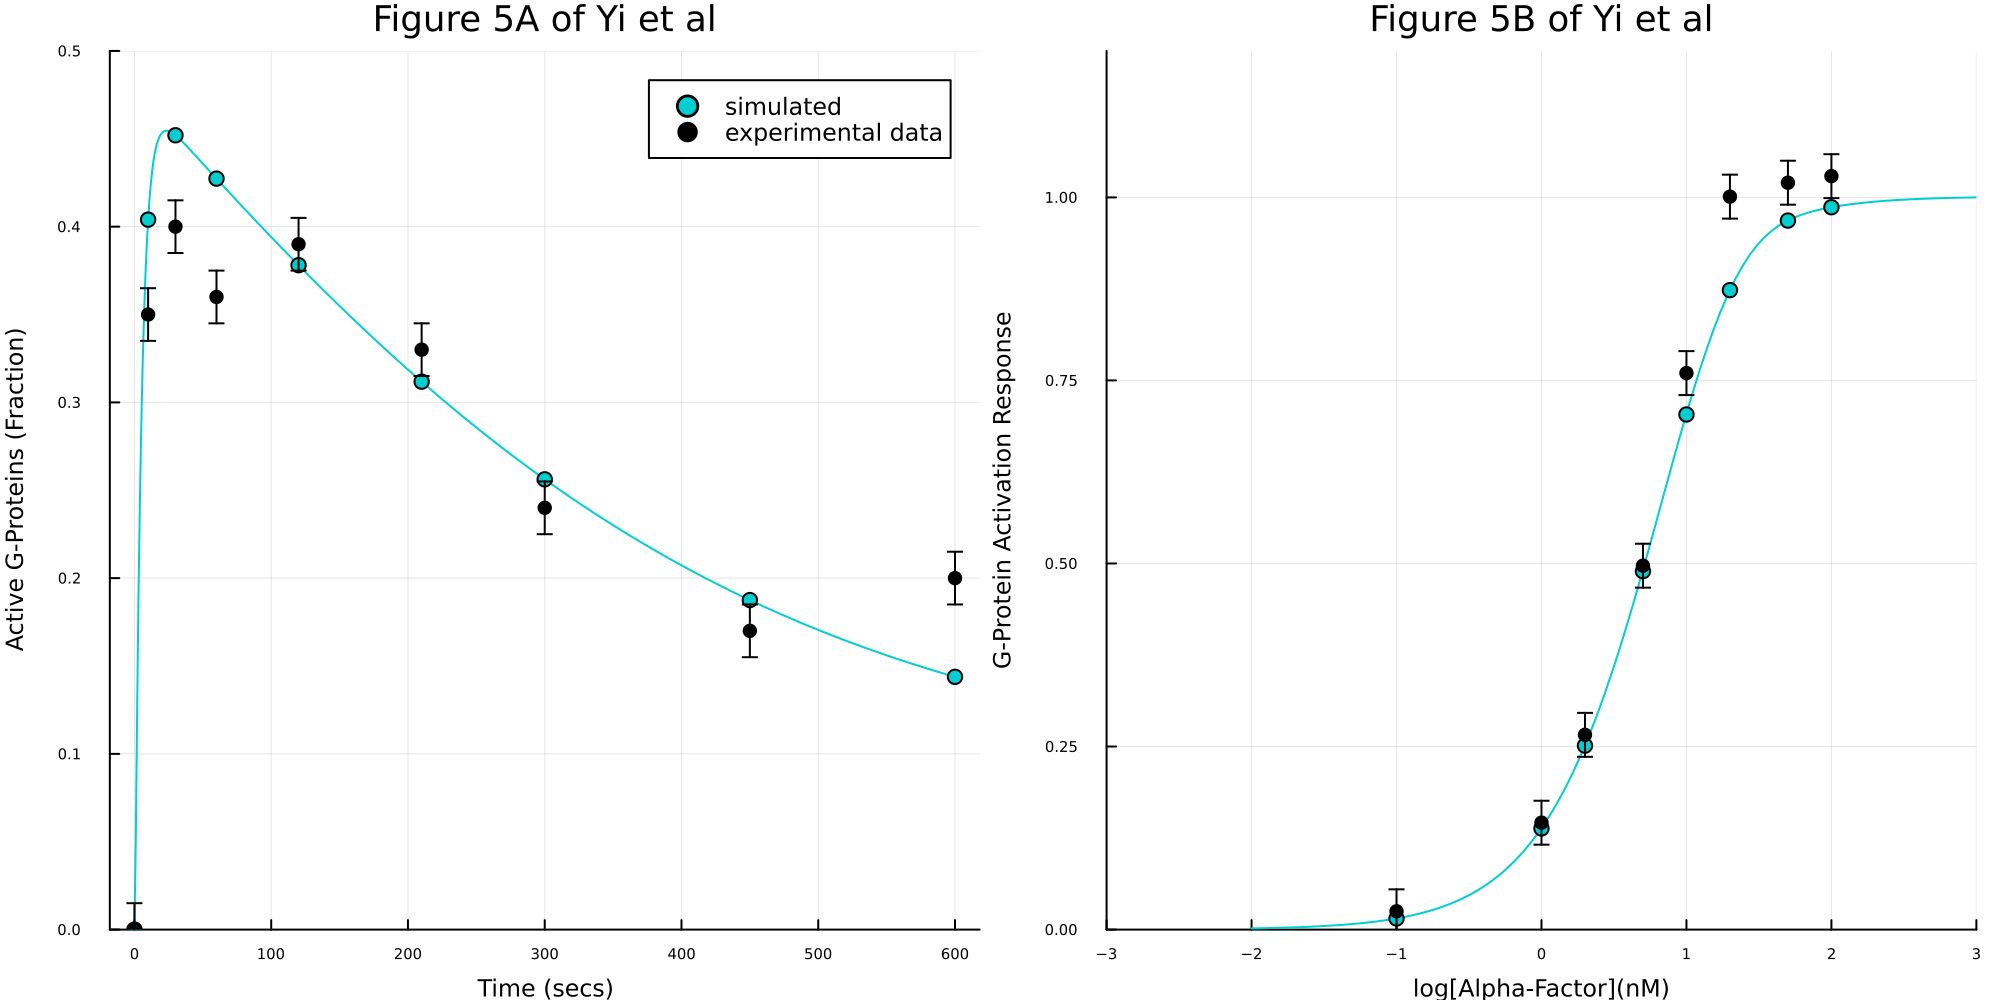

In [6]:
plot(p1,p2,layout=(1,2),dpi=200,size=(1000,500),xguidefontsize=8, yguidefontsize=8,xtickfontsize=5,ytickfontsize=5,titlefontsize=12, 
left_margin=[3Plots.mm 1Plots.mm])

In [7]:
savefig("outputs/001_yi_figure5.png")

"/Users/hollyhuber/Documents/ml_informed_binding_affinity/yi_gpcr_model/outputs/001_yi_figure5.png"

### Test Data: Receptor Affinity Dose Response Figure 4A

Note well: Unlike the previous plot, which recreates a figure from Yi et al., the following is not a one-to-one recreation of Figure 4A. Figure 4A shows several dose responses and fitted Hill curves. Here, we show data extracted from Figure 4A on one of the dose responses and the simulated dose response from the ODE model. 

In [8]:
#simulate using DifferentialEquations solver and calculate fraction of activated G protein
save_at = experiment_dose_response["save_at"]

#For dose respones, we need to change the initial ligand amound per stimulation, to provide the dose response
ligand_dosages_molecules = experiment_dose_response["ligand_stimulation (molecules)"]

#simulate for different ligand dosages
predicted_responses = []
for i in ligand_dosages_molecules
    u0 = [:R=>10000.0, :L=>i, :RL=>0.0, :Gd=>0, :Gbg=>3000.0, :G=>7000.0, :Ga=>0.0]
    op = remake(op,u0=u0)
    predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
    bound_receptor = predicted[:RL]
    append!(predicted_responses, bound_receptor)
end

#extract response we normalize to
u0 = [:R=>10000.0, :L=>experiment_dose_response["normalize_to_response_at_dose"], :RL=>0.0, :Gd=>0, :Gbg=>3000.0, :G=>7000.0, :Ga=>0.0]
op = remake(op, u0=u0)
predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
normalize_to = predicted[:RL]

#note, 1 uM corresponds to last stored dose response
scaled_response = predicted_responses./normalize_to;

#simulate for different ligand dosages - finegrain for visualization
predicted_responses = []
ligand_dosages_molecules = 10.0 .^collect(range(start=-2,stop=3,length=100)) .* 1e-9 .*6.022e23
for i in ligand_dosages_molecules
    u0 = [:R=>10000.0, :L=>i, :RL=>0.0, :Gd=>0, :Gbg=>3000.0, :G=>7000.0, :Ga=>0.0]
    op = remake(op,u0=u0)
    predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
    bound_receptor = predicted[:RL]
    append!(predicted_responses, bound_receptor)
end

#extract response we normalize to
u0 = [:R=>10000.0, :L=>experiment_dose_response["normalize_to_response_at_dose"], :RL=>0.0, :Gd=>0, :Gbg=>3000.0, 
:G=>7000.0, :Ga=>0.0]
op = remake(op,u0=u0)
predicted = DifferentialEquations.solve(op, QNDF(), abstol=1e-5, reltol=1e-6, saveat=save_at);
normalize_to = predicted[:RL]

#note, 1 uM corresponds to last stored dose response
scaled_response_finegrain = predicted_responses./normalize_to;

#plot
#load ligand concentrations in nM from CSV
using CSV, DataFrames
dose_response_exp_ligand_nM = DataFrame(CSV.File("data/active_G_dose_response.csv"))[!,"dose(log nM)"];
p2 = plot(collect(range(start=-2,stop=3,length=100)) , scaled_response_finegrain, label=false, color="darkturquoise")
scatter!(dose_response_exp_ligand_nM, scaled_response, label="simulated", color="darkturquoise")
scatter!(dose_response_exp_ligand_nM, test_dose_response["response"], label="experimental data", color="black", yerr=experiment_dose_response["average_error"])
xlabel!("log[Alpha-Factor](nM)")
ylabel!("Receptor Affinity")
xlims!(-3,3)
ylims!(0,1.2)
title!("Data from 4A of Yi et al (Logscale)")

plot(p2, dpi=200,size=(1000,500),xguidefontsize=8, yguidefontsize=8,xtickfontsize=5,ytickfontsize=5,titlefontsize=12, 
left_margin=[3Plots.mm 1Plots.mm])

savefig("outputs/001_test_data_from_yi_figure4a.png")

"/Users/hollyhuber/Documents/ml_informed_binding_affinity/yi_gpcr_model/outputs/001_test_data_from_yi_figure4a.png"